In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

from nltk.tokenize.treebank import TreebankWordDetokenizer
%matplotlib inline

# Downloading and Preprocessing the Data

In [3]:
df = pd.read_csv('../data/ner_dataset.csv', encoding = "ISO-8859-1")
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 11129,the,NN,O
freq,1,52573,145807,887908


In [4]:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
print(df['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [6]:
df = df.fillna(method = 'ffill')

In [7]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [8]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [9]:
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [10]:
sentences = getter.sentences

In [11]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [12]:
reduced_tag_set = ['B-geo', 'B-gpe', 'B-org', 'B-per', 'B-tim', 'I-geo',
                   'I-gpe', 'I-org', 'I-per', 'I-tim', 'O']

In [13]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
y = [[label if label in reduced_tag_set else 'O' for label in y_i] for y_i in y]  # reduce tag set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05)

In [15]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)

# GMB-Simple-Blurry

In [16]:
import copy, random

def blur_labels(y, frac=0.25):
    y_new = []
    error_array = []
    
    counter = 0
    
    for i in range(len(y)):
        error_array.append(list())
        y_new.append(list())
        change_steps = 0
        change_to = None
        
        for j in range(len(y[i])):
            
            current_tag = y[i][j]
            if current_tag=='B-geo' and  j >= 3:
                for k in range(3):
                    y_new[i][j - k - 1] = current_tag
                    error_array[i][j - k - 1] = True
                
                y_new[i].append(current_tag)
                error_array[i].append(False)
            else:
                error_array[i].append(False)
                y_new[i].append(current_tag)
        
    return y_new, error_array

In [17]:
y_train_new, error_train_array = blur_labels(y_train)

In [18]:
t = sum([len(a) for a in error_train_array]); print('Num tags:', t)
e = sum([sum(a) for a in error_train_array]); print('Num errs:', e)
e/t

Num tags: 797681
Num errs: 70444


0.0883109914865717

In [19]:
print(len(X_train))

36448


In [20]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.8401747361719955


In [21]:
report = flat_classification_report(y_test, y_pred, output_dict=True)
clean_precision, clean_recall, clean_f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
print(flat_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-geo       0.86      0.91      0.88      7553
       B-gpe       0.97      0.94      0.95      3143
       B-org       0.80      0.73      0.76      3965
       B-per       0.85      0.83      0.84      3462
       B-tim       0.93      0.88      0.90      4079
       I-geo       0.81      0.80      0.81      1512
       I-gpe       0.94      0.47      0.63        36
       I-org       0.81      0.77      0.79      3320
       I-per       0.85      0.90      0.87      3525
       I-tim       0.88      0.75      0.81      1357
           O       0.99      0.99      0.99    177102

   micro avg       0.97      0.97      0.97    209054
   macro avg       0.88      0.82      0.84    209054
weighted avg       0.97      0.97      0.97    209054



In [22]:
crf.fit(X_train, y_train_new)
y_pred = crf.predict(X_test)
f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
print(f1_score)

0.7609859056515412


In [23]:
report = flat_classification_report(y_test, y_pred, output_dict=True)
dirty_precision, dirty_recall, dirty_f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
print(flat_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-geo       0.26      0.87      0.40      7553
       B-gpe       0.96      0.88      0.92      3143
       B-org       0.76      0.71      0.73      3965
       B-per       0.84      0.80      0.82      3462
       B-tim       0.92      0.81      0.86      4079
       I-geo       0.82      0.60      0.69      1512
       I-gpe       0.85      0.47      0.61        36
       I-org       0.79      0.76      0.77      3320
       I-per       0.84      0.85      0.84      3525
       I-tim       0.86      0.72      0.79      1357
           O       0.99      0.90      0.94    177102

   micro avg       0.89      0.89      0.89    209054
   macro avg       0.81      0.76      0.76    209054
weighted avg       0.95      0.89      0.91    209054



# Understanding the Mistakes

### Seeing the training data

In [24]:
for i in range(10):
    print("-", end="")
    for w, word in enumerate(X_train[i]):
        word = word['word.lower()']
        if error_train_array[i][w]:
            print('*', end='')            
        if y_train_new[i][w] == 'O':
            print(word.lower(), end=' ')
        else:
            print(word.upper(), end=' ')            
    print()

-referenda held in 2006 AND 2007 to change the status of the islands from that of a NEW ZEALAND territory to one of free association with NEW ZEALAND did not meet the needed threshold for approval . 
-economists say the dollar 's decline will help close the *GAP *BETWEEN *WHAT U.S. companies sell *ABROAD *AND *WHAT U.S. consumers buy from foreign companies . 
-the virus killed six people and led to the slaughter of more than a million birds . 
-the two close allies *MET *AT *THE PALACE of the revolution TUESDAY . 
-they say it was fired from a mobile launcher at the country 's main chandipur coastal testing site , northeast of the state capital , BHUBANESHWAR . 
-the officials did not say when the clash occurred . 
-ARMY contractors drained two of 1,600 hardened steel containers at the NEWPORT CHEMICAL DEPOT and moved the nerve agent into a holding tank . 
-MR. BUSH *IS *GOING *TO HALIFAX to thank people who housed air travelers diverted during the SEPTEMBER 11 , 2001 , terrorist attac

### Seeing the predictions on the test data

In [25]:
for i in range(10):
    print("-", end="")
    for w, word in enumerate(X_test[i]):
        word = word['word.lower()']
        if y_pred[i][w] != y_test[i][w]:
            print('*', end='')
            
        if y_pred[i][w] == 'O':
            print(word.lower(), end=' ')
        else:
            print(word.upper(), end=' ')            
    print()

-the report said the diplomats are accused of trying to smuggle alleged *ETHIOPIAN *CRIMINALS *INTO KENYA . 
-the SENATE has yet to approve the bill . 
-there is currently no age minimum . 
-reports from the scene say a shootout has been under way between the remaining two inmates and security forces surrounding the prison . 
-TALEBAN fighters have been waging an insurgency since u.s.-led forces ousted the hard-line AFGHAN government in the aftermath of the SEPTEMBER 11 , 2001 attacks on *THE UNITED STATES . 
-the initial fires are being blamed on children playing with fireworks or people being careless with discarded cigarettes . 
-he said the government wants to provide maximum relief and reconstruction efforts . 
-elsewhere , authorities say suspected rebels shot dead a candidate for local *OFFICE *IN *THE *SOUTHERN *TOWN *OF JANAKPUR . 
-the plane was not hit , and GENERAL MUSHARRAF landed safely in SOUTHERN *PAKISTAN , where he spoke to victims of recent floods . 
-*KOSOVO 's ethn

# Let's Try to Fix the Mistakes

For reference, the clean F1 is: **0.84** 

In [26]:
def measure_method(error_pred, error_array, X, y_corrected):
    # measure what percent of errors are fixed
    np = 0; nn=0; tp = 0; fp = 0;
    for i in range(len(error_pred)):
        for j in range(len(error_pred[i])):
            if error_pred[i][j] and error_pred[i][j] == error_array[i][j]:
                tp += 1
            elif error_pred[i][j]:
                fp += 1
            if error_array[i][j]:
                np += 1
            else:
                nn += 1

    
    print("TP errors detected: {}".format(tp/np))
    print("FP errors detected: {}".format(fp/nn)) 

    # measure accuracy
    crf.fit(X, y_corrected)
    y_pred = crf.predict(X_test)
    f1_score = flat_f1_score(y_test, y_pred, average = 'macro')
    print("F1 score on trained model: {}".format(f1_score))
    
    report = flat_classification_report(y_test, y_pred, output_dict=True)
    precision, recall, f1 = report['B-geo']['precision'], report['B-geo']['recall'], report['B-geo']['f1-score'] 
    print(flat_classification_report(y_test, y_pred))

    return precision, recall, f1

## Pseudolabeled from Validation

In [27]:
def pseudolabeled_on_validation(X_val, y_val):
    
    crf.fit(X_val, y_val)
    y_pred = crf.predict(X_train)

    error_pred = []
    y_corrected = []

    for i in range(len(y_pred)):    
        error_pred.append([])
        y_corrected.append([])

        for j in range(len(y_pred[i])):
            if not(y_pred[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_pred)

### GTC with X, y, neighboring y

In [28]:
def gtc_with_x_y_neighboring_y(X_val, y_val):
    
    crf.fit(X_train, y_train_new)
    y_val_pred = crf.predict(X_val)

    correction_network_input = []

    for i in range(len(y_val_pred)):
        correction_network_input.append([])
        for j in range(len(y_val_pred[i])):
            correction_network_input[i].append(X_val[i][j])
            correction_network_input[i][j]['y'] = y_val_pred[i][j]     
            if j >= 1:
                correction_network_input[i][j]['y-1'] = y_val_pred[i][j-1]
            else:
                correction_network_input[i][j]['y-1'] = 'N'
            if j >= 2:
                correction_network_input[i][j]['y-2'] = y_val_pred[i][j-2]
            else:
                correction_network_input[i][j]['y-2'] = 'N'
            if j < len(y_val_pred[i]) - 1:
                correction_network_input[i][j]['y+1'] = y_val_pred[i][j+1]
            else:
                correction_network_input[i][j]['y+1'] = 'N'
            if j < len(y_val_pred[i]) - 2:
                correction_network_input[i][j]['y+2'] = y_val_pred[i][j+2]
            else:
                correction_network_input[i][j]['y+2'] = 'N'

    crf.fit(correction_network_input, y_val)

    X_expanded = []

    for i in range(len(y_train_new)):
        X_expanded.append([])
        for j in range(len(y_train_new[i])):
            X_expanded[i].append(X_train[i][j])
            X_expanded[i][j]['y'] = y_train_new[i][j]     
            if j >= 1:
                X_expanded[i][j]['y-1'] = y_train_new[i][j-1]
            else:
                X_expanded[i][j]['y-1'] = 'N'
            if j >= 2:
                X_expanded[i][j]['y-2'] = y_train_new[i][j-2]
            else:
                X_expanded[i][j]['y-2'] = 'N'
            if j < len(y_train_new[i]) - 1:
                X_expanded[i][j]['y+1'] = y_train_new[i][j+1]
            else:
                X_expanded[i][j]['y+1'] = 'N'
            if j < len(y_train_new[i]) - 2:
                X_expanded[i][j]['y+2'] = y_train_new[i][j+2]
            else:
                X_expanded[i][j]['y+2'] = 'N'

    # Go from X_expanded to X_corrected
    y_corrected = crf.predict(X_expanded)

    error_pred = []

    for i in range(len(y_corrected)):    
        error_pred.append([])    
        for j in range(len(y_corrected[i])):
            if not(y_corrected[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_corrected)

In [44]:
X_train[0][1]

{'bias': 1.0,
 'word.lower()': 'held',
 'word[-3:]': 'eld',
 'word[-2:]': 'ld',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'VBN',
 'postag[:2]': 'VB',
 '-1:word.lower()': 'referenda',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:postag': 'NNS',
 '-1:postag[:2]': 'NN',
 '+1:word.lower()': 'in',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'IN',
 '+1:postag[:2]': 'IN',
 'y': 'O',
 'y-1': 'O',
 'y-2': 'N',
 'y+1': 'O',
 'y+2': 'B-tim'}

### GTC with y, neighboring y only

In [29]:
def gtc_with_y_neighboring_y(X_val, y_val):
    
    crf.fit(X_train, y_train_new)
    y_val_pred = crf.predict(X_val)

    correction_network_input = []

    for i in range(len(y_val_pred)):
        correction_network_input.append([])
        for j in range(len(y_val_pred[i])):
            correction_network_input[i].append(dict())
            correction_network_input[i][j]['y'] = y_val_pred[i][j]     
            if j >= 1:
                correction_network_input[i][j]['y-1'] = y_val_pred[i][j-1]
            else:
                correction_network_input[i][j]['y-1'] = 'N'
            if j >= 2:
                correction_network_input[i][j]['y-2'] = y_val_pred[i][j-2]
            else:
                correction_network_input[i][j]['y-2'] = 'N'
            if j < len(y_val_pred[i]) - 1:
                correction_network_input[i][j]['y+1'] = y_val_pred[i][j+1]
            else:
                correction_network_input[i][j]['y+1'] = 'N'
            if j < len(y_val_pred[i]) - 2:
                correction_network_input[i][j]['y+2'] = y_val_pred[i][j+2]
            else:
                correction_network_input[i][j]['y+2'] = 'N'

    crf.fit(correction_network_input, y_val)

    X_expanded = []

    for i in range(len(y_train_new)):
        X_expanded.append([])
        for j in range(len(y_train_new[i])):
            X_expanded[i].append(dict())
            X_expanded[i][j]['y'] = y_train_new[i][j]     
            if j >= 1:
                X_expanded[i][j]['y-1'] = y_train_new[i][j-1]
            else:
                X_expanded[i][j]['y-1'] = 'N'
            if j >= 2:
                X_expanded[i][j]['y-2'] = y_train_new[i][j-2]
            else:
                X_expanded[i][j]['y-2'] = 'N'
            if j < len(y_train_new[i]) - 1:
                X_expanded[i][j]['y+1'] = y_train_new[i][j+1]
            else:
                X_expanded[i][j]['y+1'] = 'N'
            if j < len(y_train_new[i]) - 2:
                X_expanded[i][j]['y+2'] = y_train_new[i][j+2]
            else:
                X_expanded[i][j]['y+2'] = 'N'

    # Go from X_expanded to X_corrected
    y_corrected = crf.predict(X_expanded)

    error_pred = []

    for i in range(len(y_corrected)):    
        error_pred.append([])    
        for j in range(len(y_corrected[i])):
            if not(y_corrected[i][j]==y_train_new[i][j]):
                error_pred[i].append(True)
            else:
                error_pred[i].append(False)

    return measure_method(error_pred, error_train_array, X_train, y_corrected)

### How do results change based on validation data size?

In [30]:
gtc_with_y_neighboring_y(X_val, y_val)

TP errors detected: 1.0
FP errors detected: 0.0026648809122748157
F1 score on trained model: 0.8219957953427443
              precision    recall  f1-score   support

       B-geo       0.86      0.82      0.84      7553
       B-gpe       0.97      0.90      0.93      3143
       B-org       0.80      0.68      0.74      3965
       B-per       0.86      0.81      0.83      3462
       B-tim       0.93      0.84      0.88      4079
       I-geo       0.82      0.71      0.76      1512
       I-gpe       0.86      0.50      0.63        36
       I-org       0.81      0.74      0.77      3320
       I-per       0.82      0.90      0.86      3525
       I-tim       0.87      0.74      0.80      1357
           O       0.98      0.99      0.99    177102

   micro avg       0.97      0.97      0.97    209054
   macro avg       0.87      0.79      0.82    209054
weighted avg       0.96      0.97      0.96    209054



(0.8635352973874375, 0.8227194492254734, 0.8426333988745)

In [31]:
yny_tps = []
yny_fps = []
yny_f1s = []

ns = [25, 50, 100, 200, 400, 800, 1300, 1900]

for n in ns:
    X_val_ = X_val[:n]
    y_val_ = y_val[:n]
    tp, fp, f1 = gtc_with_y_neighboring_y(X_val_, y_val_)
    yny_tps.append(tp)
    yny_fps.append(fp)
    yny_f1s.append(f1)

TP errors detected: 1.0
FP errors detected: 0.01018650041183273


C:\Users\islam\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score on trained model: 0.7385578893711532


C:\Users\islam\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-geo       0.86      0.82      0.84      7553
       B-gpe       0.92      0.90      0.91      3143
       B-org       0.80      0.65      0.72      3965
       B-per       0.86      0.67      0.76      3462
       B-tim       0.90      0.83      0.87      4079
       I-geo       0.82      0.71      0.76      1512
       I-gpe       0.00      0.00      0.00        36
       I-org       0.79      0.73      0.76      3320
       I-per       0.84      0.88      0.86      3525
       I-tim       0.87      0.54      0.67      1357
           O       0.98      0.99      0.99    177102

   micro avg       0.96      0.96      0.96    209054
   macro avg       0.79      0.70      0.74    209054
weighted avg       0.96      0.96      0.96    209054

TP errors detected: 1.0
FP errors detected: 0.00807302158718547
F1 score on trained model: 0.7452057069599823
              precision    recall  f1-score   support

       B-geo       0.8

In [32]:
xny_tps = []
xny_fps = []
xny_f1s = []

for n in ns:
    X_val_ = X_val[:n]
    y_val_ = y_val[:n]
    tp, fp, f1 = gtc_with_x_y_neighboring_y(X_val_, y_val_)
    xny_tps.append(tp)
    xny_fps.append(fp)
    xny_f1s.append(f1)

TP errors detected: 0.9475895746976322
FP errors detected: 0.02222659188132617
F1 score on trained model: 0.34637508722899873
              precision    recall  f1-score   support

       B-geo       0.56      0.79      0.65      7553
       B-gpe       0.39      0.60      0.48      3143
       B-org       0.60      0.03      0.06      3965
       B-per       0.36      0.72      0.48      3462
       B-tim       0.31      0.49      0.38      4079
       I-geo       0.21      0.30      0.25      1512
       I-gpe       0.00      0.00      0.00        36
       I-org       0.93      0.00      0.01      3320
       I-per       0.39      0.89      0.54      3525
       I-tim       0.01      0.03      0.02      1357
           O       0.97      0.92      0.94    177102

   micro avg       0.85      0.85      0.85    209054
   macro avg       0.43      0.43      0.35    209054
weighted avg       0.90      0.85      0.86    209054

TP errors detected: 0.9393844756118335
FP errors detected: 0.

In [33]:
val_tps = []
val_fps = []
val_f1s = []

for n in ns:
    X_val_ = X_val[:n]
    y_val_ = y_val[:n]
    tp, fp, f1 = pseudolabeled_on_validation(X_val_, y_val_)
    val_tps.append(tp)
    val_fps.append(fp)
    val_f1s.append(f1)

TP errors detected: 0.9475895746976322
FP errors detected: 0.02222659188132617
F1 score on trained model: 0.34637508722899873
              precision    recall  f1-score   support

       B-geo       0.56      0.79      0.65      7553
       B-gpe       0.39      0.60      0.48      3143
       B-org       0.60      0.03      0.06      3965
       B-per       0.36      0.72      0.48      3462
       B-tim       0.31      0.49      0.38      4079
       I-geo       0.21      0.30      0.25      1512
       I-gpe       0.00      0.00      0.00        36
       I-org       0.93      0.00      0.01      3320
       I-per       0.39      0.89      0.54      3525
       I-tim       0.01      0.03      0.02      1357
           O       0.97      0.92      0.94    177102

   micro avg       0.85      0.85      0.85    209054
   macro avg       0.43      0.43      0.35    209054
weighted avg       0.90      0.85      0.86    209054

TP errors detected: 0.9393844756118335
FP errors detected: 0.

Text(0, 0.5, 'Model performance (F1 score)')

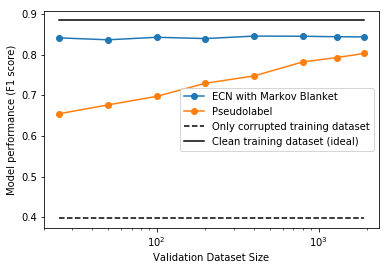

In [34]:
plt.semilogx(ns, yny_f1s, '-o', label='ECN with Markov Blanket')
plt.semilogx(ns, val_f1s, '-o', label='Pseudolabel')
plt.semilogx(ns, [dirty_f1]*len(ns), 'k--', label='Only corrupted training dataset')
plt.semilogx(ns, [clean_f1]*len(ns), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Validation Dataset Size')
plt.ylabel('Model performance (F1 score)')

Text(0, 0.5, 'Model performance (F1 score)')

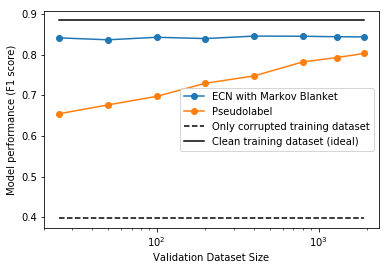

In [36]:
plt.semilogx(ns, yny_f1s, '-o', label='ECN with Markov Blanket')
plt.semilogx(ns, val_f1s, '-o', label='Pseudolabel')
plt.semilogx(ns, [dirty_f1]*len(ns), 'k--', label='Only corrupted training dataset')
plt.semilogx(ns, [clean_f1]*len(ns), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Validation Dataset Size')
plt.ylabel('Model performance (F1 score)')

Text(0.5, 1.0, 'Precision')

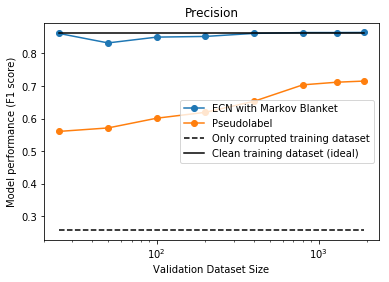

In [41]:
plt.semilogx(ns, yny_tps, '-o', label='ECN with Markov Blanket')
plt.semilogx(ns, val_tps, '-o', label='Pseudolabel')
plt.semilogx(ns, [dirty_precision]*len(ns), 'k--', label='Only corrupted training dataset')
plt.semilogx(ns, [clean_precision]*len(ns), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Validation Dataset Size')
plt.ylabel('Model performance (F1 score)')
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

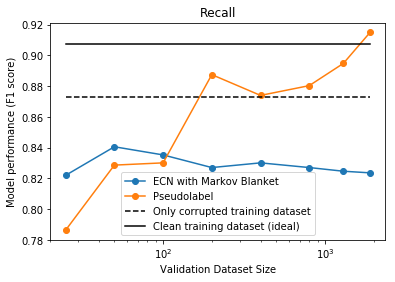

In [43]:
plt.semilogx(ns, yny_fps, '-o', label='ECN with Markov Blanket')
plt.semilogx(ns, val_fps, '-o', label='Pseudolabel')
plt.semilogx(ns, [dirty_recall]*len(ns), 'k--', label='Only corrupted training dataset')
plt.semilogx(ns, [clean_recall]*len(ns), 'k-', label='Clean training dataset (ideal)')
plt.legend()
plt.xlabel('Validation Dataset Size')
plt.ylabel('Model performance (F1 score)')
plt.title('Recall')